In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special
import random
from operator import itemgetter
import bisect

Skip to Main Figures header to reproduce plots in paper.

The basic form of our problem is that an individual has a preference for a threshold value in the unit-interval, but we can only solicit the direction of the optimum relative to a comparison threshold. In practice, the closer the more likely our comparison will return the wrong result. 

**Theorem:** Say we have an oracle that given $\lambda \in [0,1]$ points in the direction of $\lambda_0$. The Bayesian update for the location of $\lambda_0$ given a collection of oracle queries is a simple function.

**Proof:** We have,
$$
P(\text{Optimum is at } \lambda_0 | \text{Right Preference at } \lambda) $$ $$ = \cfrac{P(\text{Right Preference at } \lambda | \text{Optimum is at } \lambda_0) \cdot P(\text{Optimum is at } \lambda_0)}{\sum_i P(\text{Preference}_i \text{ at } \lambda | \text{Optimum is at } \lambda_0)} $$ $$
\Rightarrow P_{n+1}(\text{Optimum is at } \lambda_0)= \begin{cases} \cfrac{\alpha}{N} P_n(\text{Optimum is at } \lambda_0) \ \lambda > \lambda_0 \\
\cfrac{1-\alpha}{N} P_n(\text{Optimum is at } \lambda_0) \text{ otherwise} \end{cases}
$$
Since $P_0 = 1$ then $P_1$ is a simple function. Assume for $k = n$ we have that $P_k$ is a simple function. From the above, if $P_k$ is a smple function we see $P_{k+1}$ is a simple function. By induction, $P_n$ for all $n$ is a simple function.

This will guide the creation of our basic data-type for individual preferences since this we now know these will be a simple-function of the queries.

In [2]:
class Simple_Dist:
    
    # param = [(x,density)]
    # constructed left-to-right on [init[0][0],end]
    # dist pairs stored as inclusive left end
    def __init__(self, init, end):
        self.param = init
        self.start = init[0][0]
        self.end = end
        
    def display(self):
        points = []
        a_param = self.param + [(self.end,self.param[-1][1])]
        for i, v in enumerate(a_param[:-1]):
            points.append(v)
            points.append((a_param[i+1][0],v[1]))
        x,y = zip(*points)
        plt.plot(x,y)
        plt.title("Median Density")
        plt.ylabel("Density")
        plt.xlabel("Value")
    
    def cdf(self,threshold):
        basis = []
        val = []
        a_param = self.param + [(self.end,self.param[-1][1])]
        for i, v in enumerate(a_param):
            if v[0] < threshold:
                basis.append(v[0])
                val.append(v[1])
            else:
                basis.append(threshold)
                cdf = 0
                for i, d in enumerate(val):
                    cdf += d*(basis[i+1]-basis[i])
                return cdf
    
    def invcdf(self, prob):
      a_param = self.param + [(self.end,self.param[-1][1])]
      cdf = 0
      for i, v in enumerate(a_param[:-1]):
        if cdf+v[1]*(a_param[i+1][0]-a_param[i][0])>prob:
          exceed = cdf+v[1]*(a_param[i+1][0]-a_param[i][0])-prob
          return a_param[i+1][0]-exceed/v[1]
        else:
          cdf += v[1]*(a_param[i+1][0]-a_param[i][0])
      return self.end

    def median(self):
      return self.invcdf(0.5)

    # Vote indicates 
    def update_dist_interval(self, left, right, vote, alpha = 0.1):

        temp = self.param+[(self.end,self.param[-1][1])]
        
        # Insert new data(s)
        # index1 = next(i for i,v in enumerate(self.param+[(self.end,self.param[-1][1])]) if right <= v[0])
        index1 = 0
        for i in range(len(temp)):
          if temp[i][0] > right:
            break
          index1 += 1

        if index1 < len(self.param) and self.param[index1][0] != right:
            self.param.insert(index1,(right,self.param[index1-1][1]))
        elif index1 >= len(self.param) and right != self.end:
            self.param.insert(index1,(right,self.param[index1-1][1]))

        index2 = 0
        for i in range(len(temp)):
          if temp[i][0] >= left:
            break
          index2 += 1
          
        if index2 < len(self.param) and self.param[index2][0] != left:
            self.param.insert(index2,(left,self.param[index2-1][1]))
        elif index2 >= len(self.param):
            self.param.insert(index2,(left,self.param[index2-1][1]))
            
        # Modify distribution
        if vote == -1:
            # r_mass = 1 - self.cdf(right)
            for i, v in enumerate(self.param):
                # print(v)
                if left <= v[0] < right:
                    # print('increase')
                    self.param[i] = (v[0],v[1] * alpha)
                else:
                    self.param[i] = (v[0],v[1] * (1 - alpha))
                    # print('decrease')

            norm = self.cdf(self.end)
            for i, v in enumerate(self.param):
                self.param[i] = (v[0], v[1]/norm)
        else:
            # l_mass = self.cdf(right)
            for i, v in enumerate(self.param):
                # print(v)
                if left <= v[0] < right:
                    # print('increase')
                    self.param[i] = (v[0],v[1] * (1 - alpha))
                else:
                    self.param[i] = (v[0],v[1] * alpha)
                    # print('decrease')

            norm = self.cdf(self.end)
            for i, v in enumerate(self.param):
                self.param[i] = (v[0], v[1]/norm)
            # print('end')

    def update_dist(self, threshold, vote, alpha = 0.1):
          
          # Insert new data
          index = next(i for i,v in enumerate(self.param+[(self.end,self.param[-1][1])]) if threshold < v[0])
          if index < len(self.param) and self.param[index][0] != threshold:
              self.param.insert(index,(threshold,self.param[index-1][1]))
          elif index >= len(self.param):
              self.param.insert(index,(threshold,self.param[index-1][1]))
              
          # Modify distribution
          if vote == -1:
              r_mass = 1 - self.cdf(threshold)
              for i, v in enumerate(self.param):
                  if v[0] < threshold:
                      self.param[i] = (v[0],v[1] * (1 - alpha))
                  else:
                      self.param[i] = (v[0],v[1] * alpha)
              norm = self.cdf(self.end)
              for i, v in enumerate(self.param):
                  self.param[i] = (v[0], v[1]/norm)
          else:
              l_mass = self.cdf(threshold)
              for i, v in enumerate(self.param):
                  if v[0] >= threshold:
                      self.param[i] = (v[0],v[1] * (1 - alpha))
                  else:
                      self.param[i] = (v[0],v[1] * alpha)
              norm = self.cdf(self.end)
              for i, v in enumerate(self.param):
                  self.param[i] = (v[0], v[1]/norm)

The PBA is a core-routine behind CIDT and ERM is a core-routine behind IDT. 

In [3]:
def pba(iteration, alpha, decision_rule, alpha_t = 0):
    if alpha_t == 0:
        alpha_t = alpha
    dist = Simple_Dist([(0,1)],1)
#     dist.update_dist(0.5,1, alpha = alpha)
    query = np.random.rand(2)
    func = lambda x : x*(1-x)
    run= []
    for i in range(iteration):
        if not decision_rule(query[0]):
            if query[1] > alpha:
                dist.update_dist(query[0],1, alpha = alpha_t)
            else:
                dist.update_dist(query[0],-1, alpha = alpha_t)
        else:
            if query[1] > alpha:
                dist.update_dist(query[0],-1, alpha = alpha_t)
            else:
                dist.update_dist(query[0],1, alpha = alpha_t)
        query = [dist.median(),np.random.rand()]
        run.append(dist.median())
    return np.array(run) , dist.median()

def erm(labeled_size, label_probs, label_features, decision_rule, ground_rule, q, start = 1):
    interim_loss = []
    for j in range(start,labeled_size + 1):
        sub_probs = label_features[:j]
        sub_p = label_probs[:j]
        #print(list(map(decision_rule(0.5),sub_probs)))
        decision_pairs = lambda t : list(zip(list(map(decision_rule(t),sub_probs)), list(map(ground_rule, sub_probs))))
        loss = lambda a: int((2*a[0]-1)*(2*a[1]-1) > 0) + q*int((2*a[0]-1)*(2*a[1]-1) <= 0)
        curve = lambda t: sum(list(map(loss,decision_pairs(t))))
        loss_curve = list(map(curve,sub_p))
        interim_loss.append(sub_p[np.argmax(loss_curve)])
    return interim_loss, interim_loss[-1]

In practice, we are given a finite collection of samples. We cannot directly invert a probability into an example. Instead, we must search for examples with approximately the correct true positive rate.

In [4]:
# Sample list of (prob,feature) pairs from a distribution
# Return sorted by prob
# Dist is over features, pdf maps features to prob, num determines sample count
# Returns sorted by increasing order
def sample_pairs(dist,pdf,num):
    feature_samples = list(dist(num))
    p_samples = list(map(pdf, feature_samples))
    pairs = list(zip(p_samples,feature_samples))
    return sorted(pairs,key=itemgetter(0))

def sort_pairs(X,pdf):
    feature_samples = list(X)
    p_samples = list(map(pdf, feature_samples))
    pairs = list(zip(p_samples,feature_samples))
    return sorted(pairs,key=itemgetter(0))

# Search over train data for pair with prob closest to input
def select(a, x, randomize = False):
    i = bisect.bisect_left(a, x)
    if i >= len(a):
        i = len(a) - 1
    elif i and a[i] - x > x - a[i - 1]:
        i = i - 1
    try:
        val = np.random.randint(-10,10)
        if randomize:
            return (i+val,a[i+val])
        return (i,a[i])
    except:
        return (i,a[i])

Below is a basic sanity check to ensure that the support of the true positive rate distribution has support on the unit interval. 

(2908, 0.7600668280560132)


(array([1797.,  228.,  165.,  158.,  158.,  124.,  160.,  204.,  264.,
        1742.]),
 array([7.92136219e-07, 1.00000598e-01, 2.00000404e-01, 3.00000209e-01,
        4.00000015e-01, 4.99999821e-01, 5.99999626e-01, 6.99999432e-01,
        7.99999238e-01, 8.99999043e-01, 9.99998849e-01]),
 <BarContainer object of 10 artists>)

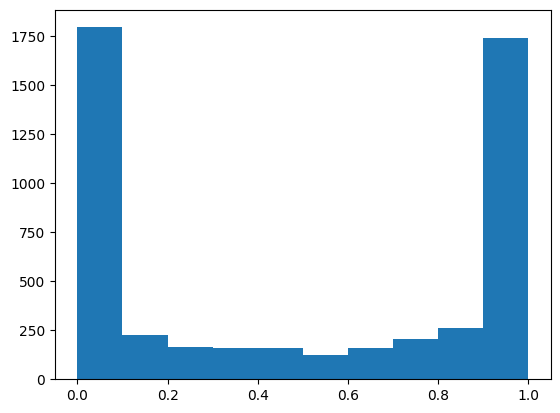

In [5]:
mean = [0, 0]
dim = 2
dist = lambda num: np.random.uniform(-10 / np.sqrt(dim),10 / np.sqrt(dim),(num,dim))
pdf = lambda x : 1/(1 + np.exp(np.sum(x)))
train_data = sample_pairs(dist,pdf,5000)
probs, features = zip(*train_data)
print(select(probs,0.76))
plt.hist(probs)

## Main Figures

In [6]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the figure title

A basic demonstration of how to reconstruct a decision rule. We'd like to emphasize that we only require that the decision rule is monotone in expectation. 

0.43523652172177507


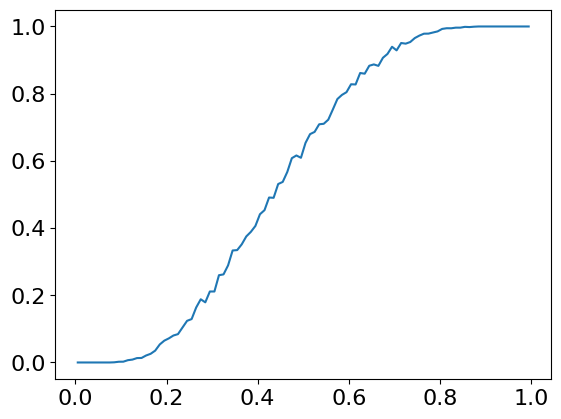

In [82]:
from scipy import stats
dim = 10
dist = lambda num: np.random.uniform(-10 / np.sqrt(dim),10 / np.sqrt(dim),(num,dim))
pdf = lambda x : 1/(1 + np.exp(np.sum(x)))
unlabeled_size = 5000
labeled_size = 100000

opt_t = np.random.uniform(0,1,1)[0]
t_true = np.random.choice([opt_t],size = 1)
#t_true = np.random.choice([opt_t,0,1],size = 10000, p = [0.8,0.1,0.1])
#t_true = np.random.beta(10*(2+np.random.uniform(0,1,1)[0]),10*(2+np.random.uniform(2,10,1)[0]), size = 10000) 

# Sample Data for IDT
labeled_data = sample_pairs(dist,pdf,labeled_size)
label_probs, label_features = zip(*labeled_data)

# Non-Systematic Errors
decision_rule = lambda p: int(p > np.random.choice(t_true, size = 1)[0])
h_labels = list(map(decision_rule, label_probs))

# Systematic Errors
vary_feat = np.random.uniform(0.8,1.2,(1,dim))
v_pdf = lambda x : 1/(1 + np.exp(np.sum(vary_feat*x)))
vary_probs = list(map(v_pdf, label_features))
h_labels = list(map(decision_rule,vary_probs))

bin_means, bin_edges, binnumber = stats.binned_statistic(label_probs, h_labels,statistic='mean', bins=100)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2
plt.figure()
plt.plot(bin_centers, bin_means, label='binned statistic of data')
plt.savefig("loss_curve_test.png",bbox_inches='tight',dpi = 600)

A basic demonstration of CIDT vs. IDT with observations from an optimal decision rule.

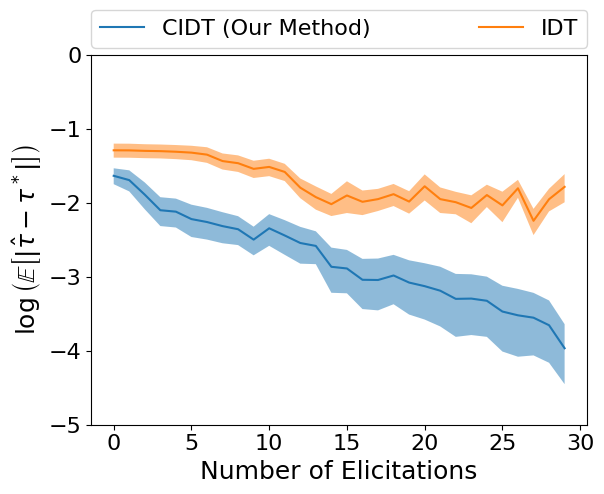

In [48]:
# First figure is with uniform sampling from a logistic model
# The decision maker is noisy with some fixed probability

noise_rate = 0.25
loss_pba = []
loss_pac = []

dim = 10
dist = lambda num: np.random.uniform(-10 / np.sqrt(dim),10 / np.sqrt(dim),(num,dim))
pdf = lambda x : 1/(1 + np.exp(np.sum(x)))
unlabeled_size = 10000
sample_size = 30
labeled_size = 30

for i in range(sample_size):
    
    opt_m = np.random.uniform(0,0.5)
    weight = [1-2*noise_rate,noise_rate,noise_rate]
    
    # Sample Data for Cooperative IDT
    train_data = sample_pairs(dist,pdf,unlabeled_size)
    probs, features = zip(*train_data)
    empirical_rule = lambda p : int(p > np.random.choice([opt_m,0,1], size = 1, p = weight)[0])

    # Sample Data for IDT
    labeled_data = sample_pairs(dist,pdf,labeled_size)
    label_probs, label_features = zip(*labeled_data)
    decision_rule = lambda t : lambda p: int(pdf(p) > t)
    ground_rule = lambda p: int(pdf(p) > np.random.choice([opt_m,0,1], size = 1, p = weight)[0])
    
    
    # Run PBA algorithm for CIDT
    hat_t, _ = pba(iteration = labeled_size, alpha = 0.0, alpha_t = noise_rate, decision_rule = empirical_rule)
    loss_pba.append((np.abs(hat_t-opt_m)))
    
    # Run ERM algorithm for IDT
    hat_r, _ = erm(labeled_size, label_probs, label_features, decision_rule, ground_rule,q=0.5)
    loss_pac.append(np.abs(np.array(hat_r.copy()).T-opt_m))

alpha = range(labeled_size)
plt.plot(alpha,np.log(np.mean(loss_pba,axis =0)), label = "CIDT (Our Method)")
plt.fill_between(alpha,np.log(np.mean(loss_pba,axis =0)-np.std(loss_pba,axis =0)/np.sqrt(labeled_size)),np.log(np.mean(loss_pba,axis =0)+np.std(loss_pba,axis =0)/np.sqrt(labeled_size)),alpha = 0.5)

plt.plot(alpha,np.log(np.mean(loss_pac,axis =0)), label = "IDT")
plt.fill_between(alpha,np.log(np.mean(loss_pac,axis =0)-np.std(loss_pac,axis =0)/np.sqrt(labeled_size)),np.log(np.mean(loss_pac,axis =0)+np.std(loss_pac,axis =0)/np.sqrt(labeled_size)),alpha = 0.5)

plt.xlabel("Number of Elicitations")
plt.ylabel(r'$\log \left(\mathbb{E} \left[ | \hat \tau - \tau^* | \right] \right)$')
plt.ylim(-5,0)
#plt.title(r'Loss vs. Elicitations ($\alpha$ = 0.25)')
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)
plt.savefig("Inference_Noise_dim_10.png", bbox_inches = 'tight',dpi = 600)

It's also possible to do elicitation in the setting where the noise rate is a function of the comparison distance. However, now we must use a power-one statistical test to determine which direction to update in. This can work by summing the oracle returns $S_m$ until we determine with high confidence the direction of the drift. We can take the cut-off point at confidence level $\gamma$ by defining,

$$k_m = (2 m (\log(m+1) - \log(\gamma)))^{1/2}$$

Where $m$ indicates the number of comparisons made up to that point in the test. The first time we have $|S_m| \ge k_m$. For our experiments we pick $\gamma = 0.1$. 

In [7]:
# t is query point
# true_t are population of preferences for threshold
# alpha is desired confidence rate
# q is desired quantile to be elicited
def vote(t,decision_rule,alpha, q = 1/2):
    S = 0
    for i in range(1,10000):
        S += (2*q-1) + decision_rule(t)
        k = np.sqrt(i*(np.log(i+1)-np.log(2*(1-alpha))))
        if S >= k:
            return True, i
        elif S <= -k:
            return False, i
    return S >= 0, 9999

def sample_vote(t,true_t):
    s_t = np.random.choice(true_t, size = (1,))
    return 2 * int(t < s_t)-1
    
def weight_run(run,weight,num,delta = 1):
    run = np.array(run)
    weight = np.array(weight)
    run = run*np.power(weight,delta)
    new_run = []
    for i, w in enumerate(list(weight)):
        for j in range(w):
            new_run.append(np.mean(run[:i+1]) / np.mean(np.power(weight[:i+1],delta)))
            #new_run.append(run[i])
    return np.array(new_run[:num])

def no_run(run,weight,num,rep = 1):
    run = np.array(run)
    run = run
    new_run = []
    for i, w in enumerate(list(weight)):
        for j in range(rep*w):
            #new_run.append(np.mean(run[:i+1]) / np.mean(np.power(weight[:i+1],1)))
            new_run.append(run[i])
    return np.array(new_run[:num])

# Implements the PTA with adaptive noise
def g_pba(num, alpha, t_phi, prior = None):
    dist = Simple_Dist([(0,1)],1)
#     dist.update_dist(0.5,1, alpha = alpha)
    query = np.random.rand(2)
    run= []
    weight = []
    s_weight = 0
    while s_weight < num:
        p = dist.invcdf(1/2)
        decision, w = t_phi(p)
        s_weight += w
        run.append(dist.invcdf(1/2))
        weight.append(w)
        if decision:
            dist.update_dist(p,1,alpha = 1-alpha)
        else:
            dist.update_dist(p,-1,alpha = 1-alpha)
    return weight_run(run,weight,num,1), dist.median()

In [50]:
alp_pta = 0.9
loss_pta = []
loss_pac = []

sample_size = 30
# desired quantile
q = 0.5

dim = 10
dist = lambda num: np.random.uniform(-10 / np.sqrt(dim),10 / np.sqrt(dim),(num,dim))
pdf = lambda x : 1/(1 + np.exp(np.sum(x)))
unlabeled_size = 5000
labeled_size = 30

for i in range(sample_size):
    t_true = np.random.beta(10*(2+np.random.uniform(0,2,1)[0]),10*(2+np.random.uniform(2,8,1)[0]), size = 10000)
    
    # Sample Data for Cooperative IDT
    train_data = sample_pairs(dist,pdf,unlabeled_size)
    probs, features = zip(*train_data)
    empirical_rule = lambda p : 2*int(select(probs,p)[1] < np.random.choice(t_true, size = 1)[0])-1
    
    # Sample Data for IDT
    labeled_data = sample_pairs(dist,pdf,labeled_size)
    label_probs, label_features = zip(*labeled_data)
    decision_rule = lambda t: lambda p : int(pdf(p) > t)
    ground_rule = lambda p: int(pdf(p) > np.random.choice(t_true, size = 1)[0])
    
    # Need to scale input/output
    hat_t, _ = g_pba(num = labeled_size, alpha =  alp_pta, t_phi = lambda t: vote(select(probs,t)[1],empirical_rule,alp_pta,q))
    hat_t = hat_t
    q_true = np.quantile(t_true,q)
    loss_pta.append(np.abs(hat_t-q_true))
    
    # Run ERM algorithm for IDT
    hat_r, _ = erm(labeled_size, label_probs, label_features, decision_rule, ground_rule, q)
    q_true = np.quantile(t_true,q)
    loss_pac.append(np.abs(np.array(hat_r.copy()).T-q_true))

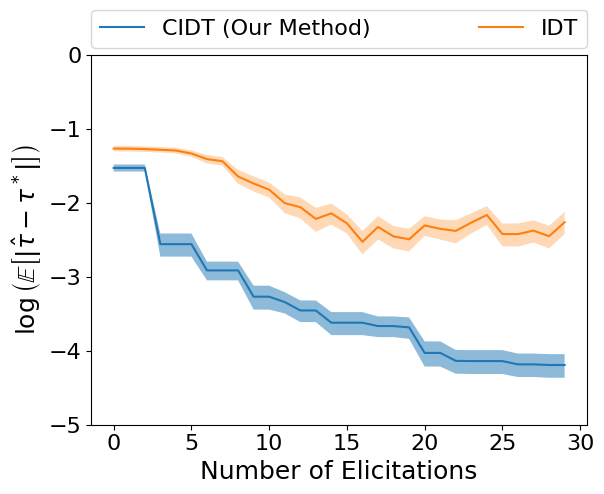

In [51]:
alpha = range(labeled_size)

plt.plot(alpha,np.log(np.mean(loss_pta, axis = 0)), label = "CIDT (Our Method)")
plt.ylim(-5, 0)
loss_pta_p = np.array(loss_pta)
plt.fill_between(alpha,np.log(np.mean(loss_pta_p, axis = 0) - np.std(loss_pta_p, axis = 0) / np.sqrt(sample_size)), np.log(np.mean(loss_pta_p, axis = 0) + np.std(loss_pta_p, axis = 0) / np.sqrt(sample_size)), alpha = 0.5)

plt.plot(alpha,np.log(np.mean(loss_pac, axis = 0)), label = "IDT")
loss_pac_p = np.array(loss_pac)
plt.fill_between(alpha,np.log(np.mean(loss_pac_p, axis = 0) - np.std(loss_pac_p, axis = 0) / np.sqrt(sample_size)), np.log(np.mean(loss_pac_p, axis = 0) + np.std(loss_pac_p, axis = 0) / np.sqrt(sample_size)), alpha = 0.3)

plt.xlabel("Number of Elicitations")
plt.ylabel(r'$\log \left(\mathbb{E} \left[ | \hat \tau - \tau^* | \right] \right)$')
plt.ylim(-5,0)
#plt.title(r'Loss vs. Elicitations ($\alpha$ = 0.25)')
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)
plt.savefig("Inference_Group_dim_10.png",bbox_inches='tight', dpi = 600)

Experiment with systematicallly suboptimal experts. We model the sub-optimality by peturbing features. 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


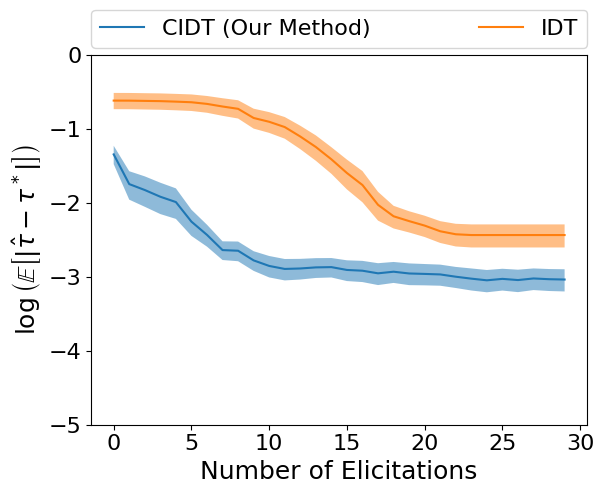

In [105]:
# First figure is with uniform sampling from a logistic model
# The decision maker is noisy with some fixed probability

noise_rate = 0.1
loss_pba = []
loss_pac = []

dim = 10
dist = lambda num: np.random.uniform(-10 / np.sqrt(dim),10 / np.sqrt(dim),(num,dim))
pdf = lambda x : 1/(1 + np.exp(np.sum(x)))
unlabeled_size = 10000
labeled_size = 30

for i in range(30):
    
    opt_t = np.random.uniform(0.0,1.0,1)
    
    # Sample Data for Cooperative IDT
    labeled_data = sample_pairs(dist,pdf,labeled_size)
    label_probs, label_features = zip(*labeled_data)
    unlabeled_data = sample_pairs(dist,pdf,unlabeled_size)
    unlabel_probs, unlabel_features = zip(*unlabeled_data)
    # Systematic Errors
    vary_feat = np.random.uniform(0.8,1.2,(1,dim))
    v_pdf = lambda x : 1/(1 + np.exp(np.sum(vary_feat*x)))
    vary_probs = list(map(v_pdf, label_features))
    empirical_rule = lambda p : int(v_pdf(unlabel_features[select(unlabel_probs,p, randomize = True)[0]]) > np.random.choice(opt_t, size = 1)[0])
    decision_rule = lambda t: lambda p : int(pdf(p) > t)
    ground_rule = lambda p: v_pdf(p) > np.random.choice(opt_t, size = 1)

    # Run ERM algorithm for IDT
    #s_data = sample_pairs(dist,pdf,50*labeled_size)
    #s_probs, s_features = zip(*s_data)
    #hat_p, _ = erm(50*labeled_size, s_probs, s_features, decision_rule, ground_rule, q = 1/2, start = 50*labeled_size-1)
    # Run PBA algorithm for CIDT
    hat_p, _ = pba(iteration = 50*labeled_size, alpha = 2*noise_rate, decision_rule = empirical_rule)
    ground_t = hat_p[-1]
    #ground_t = opt_t
    
    # Run PBA algorithm for CIDT
    hat_t, _ = pba(iteration = labeled_size, alpha = noise_rate, decision_rule = empirical_rule)
    loss_pba.append((np.abs(hat_t-ground_t)))
    
    # Run ERM algorithm for IDT
    hat_r, _ = erm(labeled_size, label_probs, label_features, decision_rule, ground_rule, q = 1/2)
    loss_pac.append(np.abs(np.array(hat_r.copy()).T-ground_t))

alpha = range(labeled_size)
plt.plot(alpha,np.log(np.mean(loss_pba,axis =0)), label = "CIDT (Our Method)")
plt.fill_between(alpha,np.log(np.mean(loss_pba,axis =0)-np.std(loss_pba,axis =0)/np.sqrt(labeled_size)),np.log(np.mean(loss_pba,axis =0)+np.std(loss_pba,axis =0)/np.sqrt(labeled_size)),alpha = 0.5)

plt.plot(alpha,np.log(np.mean(loss_pac,axis =0)), label = "IDT")
plt.fill_between(alpha,np.log(np.mean(loss_pac,axis =0)-np.std(loss_pac,axis =0)/np.sqrt(labeled_size)),np.log(np.mean(loss_pac,axis =0)+np.std(loss_pac,axis =0)/np.sqrt(labeled_size)),alpha = 0.5)

plt.xlabel("Number of Elicitations")
plt.ylabel(r'$\log \left(\mathbb{E} \left[ | \hat \tau - \tau^* | \right] \right)$')
plt.ylim(-5,0)
#plt.title(r'Loss vs. Elicitations ($\alpha$ = 0.25)')
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)
plt.savefig("Inference_Suboptimal_dim_10_approx_pba.png",bbox_inches='tight', dpi = 600)

In our final experiment we will try to extract the decision rule for a group of decision by eliciting different quantiles of the belief distribution. 

In [15]:
alp_pta = 0.9
loss_pta = []
loss_g = []
# desired quantile
quantiles = np.linspace(0.01,0.99,20, endpoint = True)
est_quantiles = []
true_quantiles = []

t_true = np.random.beta(2,5, size = 10000)
sample_size = 30
labeled_size = 50

dist = lambda num: np.random.uniform(-5,5,(num,2))
pdf = lambda x : 1/(1 + np.exp(np.sum(x)))
unlabeled_size = 5000
labeled_size = 30

# Systematic Errors
vary_feat = np.random.uniform(0.8,1.2,(1,2))
v_pdf = lambda x : 1/(1 + np.exp(np.sum(vary_feat*x)))
vary_probs = list(map(v_pdf, label_features))

# Sample Data for Cooperative IDT
train_data = sample_pairs(dist,pdf,unlabeled_size)
probs, features = zip(*train_data)
empirical_rule = lambda p : int(v_pdf(features[select(probs,p)[0]]) > np.random.choice(opt_t, size = 1)[0])


# Sample Data for IDT
labeled_data = sample_pairs(dist,pdf,labeled_size)
label_probs, label_features = zip(*labeled_data)
decision_rule = lambda t : lambda p: int(pdf(p) > t)
ground_rule = lambda p: int(v_pdf(p) > np.random.choice(opt_t, size = 1)[0])


for q in quantiles:
    true_quantiles.append(np.quantile(t_true,q))
    temp = []
    for i in range(sample_size):
        # Need to scale input/output
        hat_t, _ = g_pba(num = labeled_size, alpha =  alp_pta, t_phi = lambda t: vote(select(probs,t)[1],lambda t: sample_vote(t,t_true),alp_pta,q))
        temp.append(hat_t[-1])
        if q == 0.01:
            temp[-1] = 0
        elif q == 0.99:
            temp[-1] = 1
    est_quantiles.append(temp)

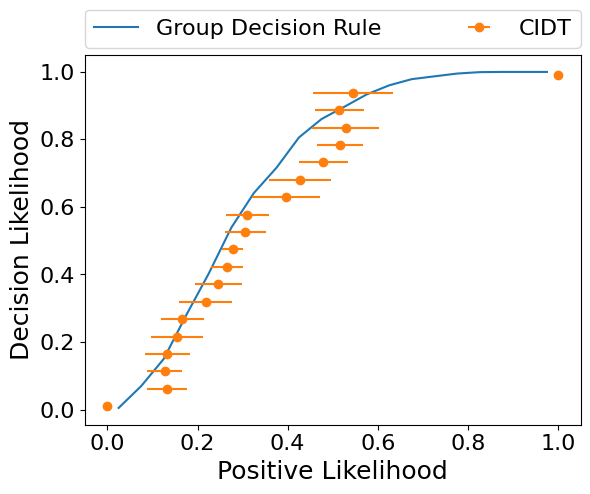

In [16]:
from scipy import stats
dist = lambda num: np.random.uniform(-5,5,(num,2))
pdf = lambda x : 1/(1 + np.exp(np.sum(x)))
unlabeled_size = 5000
labeled_size = 100000

t_true = np.random.beta(2,5, size = 1000)

# Sample Data for IDT
labeled_data = sample_pairs(dist,pdf,labeled_size)
label_probs, label_features = zip(*labeled_data)

# Non-Systematic Errors
decision_rule = lambda p: int(p > np.random.choice(t_true, size = 1)[0])
h_labels = list(map(decision_rule, label_probs))

bin_means, bin_edges, binnumber = stats.binned_statistic(label_probs, h_labels,statistic='mean', bins=20)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2
plt.figure()
plt.plot(bin_centers, bin_means, label='Group Decision Rule')
plt.errorbar(np.mean(est_quantiles, axis = 1),quantiles,xerr=np.std(est_quantiles, axis = 1), label = "CIDT", fmt='o')
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)
plt.xlabel("Positive Likelihood")
plt.ylabel("Decision Likelihood")
plt.savefig("IDT_Group_0.png",bbox_inches='tight',dpi = 600)

Noisy elicitation

In [31]:
alp_pta = 0.9
loss_pta = []
loss_g = []
# desired quantile
quantiles = np.linspace(noise_rate+0.01,0.99-noise_rate,20, endpoint = True)
est_quantiles = []
true_quantiles = []

noise_rate = 0.1
opt_m = np.random.uniform(0,0.5)
weight = [1-2*noise_rate,noise_rate,noise_rate]
sample_size = 30
labeled_size = 50

dist = lambda num: np.random.uniform(-5,5,(num,2))
pdf = lambda x : 1/(1 + np.exp(np.sum(x)))
unlabeled_size = 5000
labeled_size = 30

# Systematic Errors
vary_feat = np.random.uniform(0.8,1.2,(1,2))
v_pdf = lambda x : 1/(1 + np.exp(np.sum(vary_feat*x)))
vary_probs = list(map(v_pdf, label_features))

# Sample Data for Cooperative IDT
train_data = sample_pairs(dist,pdf,unlabeled_size)
probs, features = zip(*train_data)
empirical_rule = lambda p : int(v_pdf(features[select(probs,p)[0]]) > np.random.choice([opt_m,0,1], size = 1, p = weight)[0])

# Sample Data for IDT
labeled_data = sample_pairs(dist,pdf,labeled_size)
label_probs, label_features = zip(*labeled_data)
decision_rule = lambda t : lambda p: int(pdf(p) > t)
ground_rule = lambda p: int(v_pdf(p) > np.random.choice([opt_m,0,1], size = 1, p = weight)[0])


for q in quantiles:
    true_quantiles.append(np.quantile(t_true,q))
    temp = []
    for i in range(sample_size):
        # Need to scale input/output
        hat_t, _ = pba(iteration = labeled_size, alpha = 0.0, alpha_t = noise_rate, decision_rule = empirical_rule)
        temp.append(hat_t[-1])
        if q == noise_rate+0.01:
            temp[-1] = 0
        elif q == 0.99-noise_rate:
            temp[-1] = 1
    est_quantiles.append(temp)

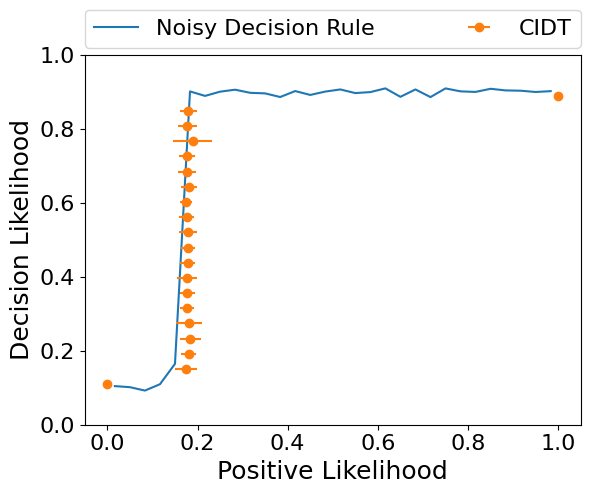

In [32]:
from scipy import stats
dist = lambda num: np.random.uniform(-5,5,(num,2))
pdf = lambda x : 1/(1 + np.exp(np.sum(x)))
unlabeled_size = 5000
labeled_size = 100000

# Sample Data for IDT
labeled_data = sample_pairs(dist,pdf,labeled_size)
label_probs, label_features = zip(*labeled_data)

# Non-Systematic Errors
decision_rule = lambda p: int(p > np.random.choice([opt_m,0,1], size = 1, p = weight)[0])
h_labels = list(map(decision_rule, label_probs))

bin_means, bin_edges, binnumber = stats.binned_statistic(label_probs, h_labels,statistic='mean', bins=30)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2
plt.figure()
plt.ylim(0, 1)
plt.plot(bin_centers, bin_means, label='Noisy Decision Rule')
plt.errorbar(np.mean(est_quantiles, axis = 1),quantiles,xerr=np.std(est_quantiles, axis = 1), label = "CIDT", fmt='o')
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)
plt.xlabel("Positive Likelihood")
plt.ylabel("Decision Likelihood")
plt.savefig("IDT_Noise_0.png",bbox_inches='tight',dpi = 600)

Suboptimal elicitation

In [40]:
alp_pta = 0.9
loss_pta = []
loss_g = []
# desired quantile
quantiles = np.linspace(0.01,0.99,20, endpoint = True)
est_quantiles = []
true_quantiles = []

opt_t = [3/4]
sample_size = 30

vary_feat = np.array([[0.9,1.2]])

for q in quantiles:
    print("Quantile " + str(q))
    true_quantiles.append(np.quantile(t_true,q))
    temp = []
    for i in range(sample_size):
        dist = lambda num: np.random.uniform(-5,5,(num,2))
        pdf = lambda x : 1/(1 + np.exp(np.sum(x)))
        unlabeled_size = 1000
        labeled_size = 50

        # Systematic Errors
        v_pdf = lambda x : 1/(1 + np.exp(np.sum(vary_feat*x)))
        vary_probs = list(map(v_pdf, label_features))

        # Sample Data for Cooperative IDT
        train_data = sample_pairs(dist,pdf,unlabeled_size)
        probs, features = zip(*train_data)
        empirical_rule = lambda p : 2*int(v_pdf(features[select(probs,p,randomize = True)[0]]) < np.random.choice(opt_t, size = 1)[0])-1

        # Need to scale input/output
        #hat_t, _ = pba(iteration = labeled_size, alpha = noise_rate, decision_rule = empirical_rule)
        hat_t, _ = g_pba(num = labeled_size, alpha =  alp_pta, t_phi = lambda t: vote(t,empirical_rule,alp_pta,q))
        temp.append(hat_t[-1])
        if q == 0.01:
            temp[-1] = 0
        elif q == 0.99:
            temp[-1] = 1
    est_quantiles.append(temp)

0.01
0.06157894736842105
0.1131578947368421
0.16473684210526315
0.2163157894736842
0.26789473684210524
0.3194736842105263
0.37105263157894736
0.4226315789473684
0.47421052631578947
0.5257894736842105
0.5773684210526315
0.6289473684210526
0.6805263157894736
0.7321052631578947
0.7836842105263158
0.8352631578947368
0.8868421052631579
0.9384210526315789
0.99


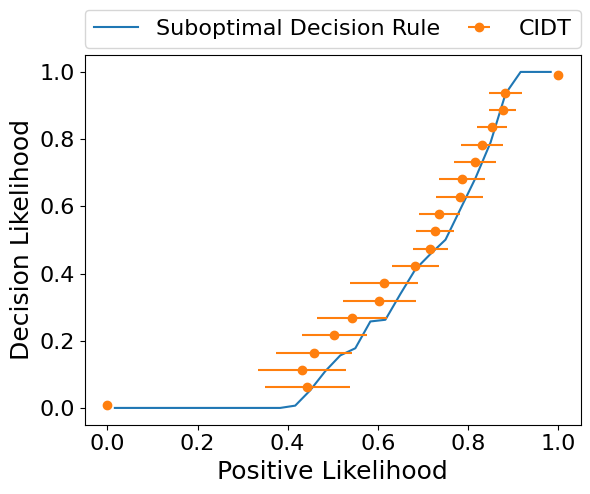

In [41]:
from scipy import stats
dist = lambda num: np.random.uniform(-5,5,(num,2))
pdf = lambda x : 1/(1 + np.exp(np.sum(x)))
unlabeled_size = 5000
labeled_size = 100000

t_true = opt_t

# Sample Data for IDT
labeled_data = sample_pairs(dist,pdf,labeled_size)
label_probs, label_features = zip(*labeled_data)

# Non-Systematic Errors
decision_rule = lambda p: int(p > np.random.choice(t_true, size = 1)[0])
h_labels = list(map(decision_rule, label_probs))

# Systematic Errors
v_pdf = lambda x : 1/(1 + np.exp(np.sum(vary_feat*x)))
vary_probs = list(map(v_pdf, label_features))
h_labels = list(map(decision_rule,vary_probs))

bin_means, bin_edges, binnumber = stats.binned_statistic(label_probs, h_labels,statistic='mean', bins=30)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2
plt.figure()
plt.plot(bin_centers, bin_means, label='Suboptimal Decision Rule')
plt.errorbar(np.mean(est_quantiles, axis = 1),quantiles,xerr=np.std(est_quantiles, axis = 1), label = "CIDT", fmt='o')
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)
plt.xlabel("Positive Likelihood")
plt.ylabel("Decision Likelihood")
plt.savefig("IDT_Suboptimal_0.png",bbox_inches='tight',dpi = 600)

We include an experiment with real data

In [8]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Pick Your File
with open("wdbc.data") as fp:
    reader = csv.reader(fp, delimiter=",", quotechar='"')
    # next(reader, None)  # skip the headers
    data_read = [row for row in reader]
    
# Format data
pre_data = []
for i in range(1,len(data_read)):
    datum = []
    if data_read[i][1] == 'M':
        datum.append(1.0)
    else:
        datum.append(0.0)
        
    for item in data_read[i][2:]:
        datum.append(float(item))
    pre_data.append(datum)
    
format_data = np.array(pre_data)

# Prepare Data
X = format_data[:,1:]
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)
y = format_data[:,0]

We also display the histogram of likelihoods. We they are relatively concentrated at the extremes.

0.9565217391304348


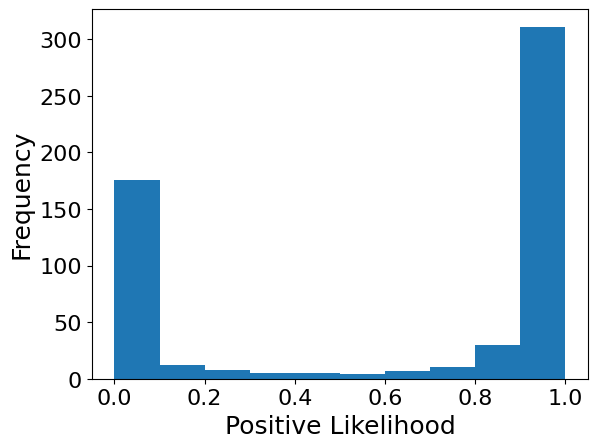

In [28]:
from scipy import stats
dist = lambda num: np.random.uniform(-5,5,(num,2))
pdf = lambda x : 1/(1 + np.exp(np.sum(x)))
unlabeled_size = 5000
labeled_size = 100000

opt_t = np.random.uniform(0,1,1)[0]
t_true = np.random.choice([opt_t],size = 1)

# Prepare Data
X = format_data[:,1:]
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)
y = format_data[:,0]
# Fit Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.08, random_state=0)
logreg = LogisticRegression(C= 0.25)
logreg.fit(X_train, y_train)
print(logreg.score(X_test,y_test))

pdf = lambda p : logreg.predict_proba([p])[:,0]

p_train = logreg.predict_proba(X_train)[:,0]
p_test = logreg.predict_proba(X_test)[:,0]
unlabeled_size = len(p_train)
labeled_size = len(p_test)

opt_t = np.random.uniform(0,1.0,1)

# Sample Data for Cooperative IDT
train_data = sort_pairs(X,pdf)
label_probs, label_features = zip(*train_data)
label_probs = [label_probs[i][0] for i in range(len(label_probs))]

# Non-Systematic Errors
decision_rule = lambda p: int(p > np.random.choice(t_true, size = 1)[0])
h_labels = list(map(decision_rule, label_probs))
# Systematic Errors
# Prepare Data
X = format_data[:,3:]
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)
y = format_data[:,0]
# Fit Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.08, random_state=0)
logreg = LogisticRegression(C = 0.25)
logreg.fit(X, y)
# Sample Data for Cooperative IDT
v_pdf = lambda p : logreg.predict_proba([p[2:]])[:,0]
vary_probs = list(map(v_pdf, label_features))
h_labels = list(map(decision_rule,vary_probs))

#bin_means, bin_edges, binnumber = stats.binned_statistic(label_probs, h_labels,statistic='mean', bins=100)
#bin_width = (bin_edges[1] - bin_edges[0])
#bin_centers = bin_edges[1:] - bin_width/2
#plt.figure()
#plt.plot(bin_centers, bin_means, label='binned statistic of data')
plt.hist(label_probs)
plt.xlabel("Positive Likelihood")
plt.ylabel("Frequency")
plt.savefig("likelihood_hist_cancer.png",bbox_inches='tight',dpi = 600)

In [43]:
# First figure is with uniform sampling from a logistic model
# The decision maker is noisy with some fixed probability

noise_rate = 0.05
loss_pba = []
loss_pac = []

dist = lambda num: np.random.uniform(-5,5,(num,2))
pdf = lambda x : 1/(1 + np.exp(np.sum(x)))
unlabeled_size = 5000
labeled_size = 30
ft_size = 30

print("Feature subset size: " + str(ft_size))

for i in range(30):

    # Prepare Data
    X = format_data[:,1:]
    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)
    y = format_data[:,0]
    # Fit Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.07, random_state=0)
    logreg = LogisticRegression(C = 0.25)
    logreg.fit(X, y)
    
    pdf = lambda p : logreg.predict_proba([p])[:,0]

    p_train = logreg.predict_proba(X_train)[:,0]
    p_test = logreg.predict_proba(X_test)[:,0]
    unlabeled_size = len(p_train)
    labeled_size = len(p_test)
    
    opt_t = np.random.uniform(0.0,1.0,1)
    
    # Sample Data for Cooperative IDT
    train_data = sort_pairs(X_train,pdf)
    probs, features = zip(*train_data)
    #probs = p_train
    #features = X
    # Systematic Errors/ Decide features to use
    idx = np.random.choice(list(range(30)), size=ft_size)
    Xp = format_data[:,idx+1]
    scaler = preprocessing.StandardScaler().fit(Xp)
    Xp = scaler.transform(Xp)
    yp = format_data[:,0]
    # Fit Data
    Xp_train, Xp_test, yp_train, yp_test = train_test_split(Xp, yp, test_size=0.07, random_state=0)
    logreg_1 = LogisticRegression(C = 0.25)
    logreg_1.fit(Xp, yp)
    # Sample Data for Cooperative IDT
    # Number of features to use:
    v_pdf = lambda p : logreg_1.predict_proba([p[idx]])[:,0]
    empirical_rule = lambda p : int(v_pdf(features[select(probs,p,randomize= True)[0]]) > np.random.choice(opt_t, size = 1)[0])

    # Sample Data for IDT
    #labeled_data = sample_pairs(dist,pdf,labeled_size)
    #label_probs, label_features = zip(*labeled_data)
    # Prepare Data
    label_probs = p_test
    label_features = X_test
    decision_rule = lambda t : lambda p: int(pdf(p) > t)
    ground_rule = lambda p: int(v_pdf(p) > np.random.choice(opt_t, size = 1)[0])
    
    # Run ERM algorithm for IDT
    hat_r, _ = erm(unlabeled_size, logreg.predict_proba(X_train)[:,0], features, decision_rule, ground_rule, q = 1/2, start = unlabeled_size)
    ground_t = hat_r[0]
    
    # Run PBA algorithm for CIDT
    hat_t, _ = pba(iteration = labeled_size, alpha = noise_rate, decision_rule = empirical_rule)
    loss_pba.append((np.abs(hat_t-ground_t)))
    
    # Run ERM algorithm for IDT
    hat_r, _ = erm(labeled_size, label_probs, label_features, decision_rule, ground_rule, q = 1/2)
    loss_pac.append(np.abs(np.array(hat_r.copy()).T-ground_t))


print("CIDT Error:")
print(np.mean(loss_pba,axis =0))

print("IDT Error:")
print(np.mean(loss_pac,axis =0))

Feature subset size: 30
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
CIDT Error:
[0.19488001 0.17279182 0.13143423 0.10453239 0.0954756  0.07459502
 0.0611137  0.05387992 0.04872247 0.04645468 0.04960603 0.05605015
 0.05064937 0.04859591 0.04886156 0.0457957  0.05362736 0.05380582
 0.05206164 0.05177145 0.05102454 0.04995582 0.0499074  0.04849129
 0.04686335 0.04853652 0.04831201 0.04768464 0.04687532 0.04717667
 0.04744261 0.04745235 0.04738138 0.04734512 0.04734351 0.04729958
 0.04724719 0.04721569 0.04719893 0.04720511]
IDT Error:
[0.49982844 0.49812318 0.49674512 0.49674512 0.26261565 0.26261565
 0.26213734 0.26201402 0.26201402 0.26201402 0.2621144  0.23258549
 0.19740719 0.19740719 0.19357946 0.19357946 0.19357946 0.19357946
 0.19357946 0.19357946 0.19357946 0.19357946 0.19357946 0.19357946
 0.19357946 0.19357946 0.19495752 0.19495752 0.19495752 0.19495752
 0.19495752 0.19495752 0.19495752 0.17078147 0.11278388 0.11204725
 0.12139818 0.12139818 

0
[0.07677182041784303]
(array([0.15718362]), 0.07677182041784303)
1
[0.9126547252261393]
(array([0.80672329]), 0.9126547252261393)
2
[0.004950407745616836]
(array([0.03449938]), 0.004950407745616836)
3
[0.22445979216421474]
(array([0.40325335]), 0.22445979216421474)
4
[0.08153639167477889]
(array([0.12676199]), 0.08153639167477889)
5
[0.03747407629093025]
(array([0.12591659]), 0.03747407629093025)
6
[0.9218145453220876]
(array([0.94033288]), 0.9218145453220876)
7
[0.056003960212901105]
(array([0.06795682]), 0.056003960212901105)
8
[0.8176776047612853]
(array([0.77284028]), 0.8176776047612853)
9
[0.8176776047612853]
(array([0.84273487]), 0.8176776047612853)
10
[0.8427794937206335]
(array([0.83952221]), 0.8427794937206335)
11
[0.8403454488060869]
(array([0.86830823]), 0.8403454488060869)
12
[0.02636120814866283]
(array([0.14013896]), 0.02636120814866283)
13
[0.007097531709702287]
(array([0.01045861]), 0.007097531709702287)
14
[0.02636120814866283]
(array([0.0634949]), 0.0263612081486628

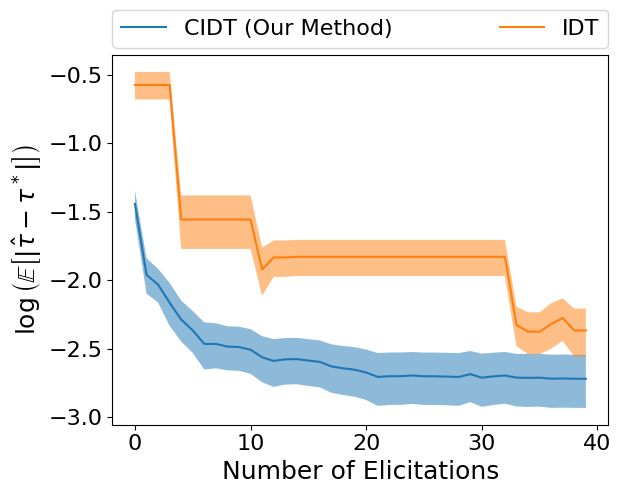

In [23]:
# First figure is with uniform sampling from a logistic model
# The decision maker is noisy with some fixed probability

noise_rate = 0.05
loss_pba = []
loss_pac = []

dist = lambda num: np.random.uniform(-5,5,(num,2))
pdf = lambda x : 1/(1 + np.exp(np.sum(x)))
unlabeled_size = 5000
labeled_size = 10

for i in range(30):

    # Prepare Data
    X = format_data[:,1:]
    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)
    y = format_data[:,0]
    # Fit Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.07, random_state=0)
    logreg = LogisticRegression(C = 0.25)
    logreg.fit(X, y)
    
    pdf = lambda p : logreg.predict_proba([p])[:,0]

    p_train = logreg.predict_proba(X_train)[:,0]
    p_test = logreg.predict_proba(X_test)[:,0]
    unlabeled_size = len(p_train)
    labeled_size = len(p_test)
    
    opt_t = np.random.uniform(0.0,1.0,1)
    
    # Sample Data for Cooperative IDT
    train_data = sort_pairs(X_train,pdf)
    probs, features = zip(*train_data)
    #probs = p_train
    #features = X
    # Systematic Errors/ Decide features to use
    idx = np.random.choice(list(range(30)), size=25)
    Xp = format_data[:,idx+1]
    scaler = preprocessing.StandardScaler().fit(Xp)
    Xp = scaler.transform(Xp)
    yp = format_data[:,0]
    # Fit Data
    Xp_train, Xp_test, yp_train, yp_test = train_test_split(Xp, yp, test_size=0.07, random_state=0)
    logreg_1 = LogisticRegression(C = 0.25)
    logreg_1.fit(Xp, yp)
    # Sample Data for Cooperative IDT
    # Number of features to use:
    v_pdf = lambda p : logreg_1.predict_proba([p[idx]])[:,0]
    empirical_rule = lambda p : int(v_pdf(features[select(probs,p,randomize= True)[0]]) > np.random.choice(opt_t, size = 1)[0])

    # Sample Data for IDT
    #labeled_data = sample_pairs(dist,pdf,labeled_size)
    #label_probs, label_features = zip(*labeled_data)
    # Prepare Data
    label_probs = p_test
    label_features = X_test
    decision_rule = lambda t : lambda p: int(pdf(p) > t)
    ground_rule = lambda p: int(v_pdf(p) > np.random.choice(opt_t, size = 1)[0])
    
    # Run ERM algorithm for IDT
    hat_r, _ = erm(unlabeled_size, logreg.predict_proba(X_train)[:,0], features, decision_rule, ground_rule, q = 1/2, start = unlabeled_size)
    print(hat_r)
    ground_t = hat_r[0]
    
    print((opt_t,ground_t))
    
    # Run PBA algorithm for CIDT
    hat_t, _ = pba(iteration = labeled_size, alpha = noise_rate, decision_rule = empirical_rule)
    loss_pba.append((np.abs(hat_t-ground_t)))
    
    
    # Run ERM algorithm for IDT
    hat_r, _ = erm(labeled_size, label_probs, label_features, decision_rule, ground_rule, q = 1/2)
    loss_pac.append(np.abs(np.array(hat_r.copy()).T-ground_t))

alpha = range(labeled_size)
plt.plot(alpha,np.log(np.mean(loss_pba,axis =0)), label = "CIDT (Our Method)")
plt.fill_between(alpha,np.log(np.mean(loss_pba,axis =0)-np.std(loss_pba,axis =0)/np.sqrt(labeled_size)),np.log(np.mean(loss_pba,axis =0)+np.std(loss_pba,axis =0)/np.sqrt(labeled_size)),alpha = 0.5)

plt.plot(alpha,np.log(np.mean(loss_pac,axis =0)), label = "IDT")
plt.fill_between(alpha,np.log(np.mean(loss_pac,axis =0)-np.std(loss_pac,axis =0)/np.sqrt(labeled_size)),np.log(np.mean(loss_pac,axis =0)+np.std(loss_pac,axis =0)/np.sqrt(labeled_size)),alpha = 0.5)

plt.xlabel("Number of Elicitations")
plt.ylabel(r'$\log \left(\mathbb{E} \left[ | \hat \tau - \tau^* | \right] \right)$')
#plt.ylim(-5,0)
#plt.title(r'Loss vs. Elicitations ($\alpha$ = 0.25)')
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)
plt.savefig("Inference_Cancer_30_features_25_runs_erm.png",bbox_inches='tight', dpi = 600)